# Decision Tree Bank Project

# Objective
Using the collected from existing customers, build a model that will help the marketing team identify potential customers who are relatively more likely to subscribe term deposit and thus increase their hit ratio.

Load Libraries and data

In [1]:
%matplotlib inline

import graphviz
import pydotplus
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn import metrics
from IPython.display import Image  
from matplotlib import pyplot as plt
from sklearn.tree import export_graphviz
from sklearn.externals.six import StringIO
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score,f1_score,recall_score,precision_score, confusion_matrix

C:\Users\User\Anaconda3\lib\site-packages\sklearn\externals\six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


In [2]:
# ignore all future warnings
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

# Deliverable – 1 (Exploratory data quality report reflecting the following) 

In [3]:
# Load Data
bank_df = pd.read_csv('bank-full.csv')

In [4]:
#Check shape of dataset
bank_df.shape

(45211, 17)

In [5]:
# Test whether there is any null value in the dataset or not.
#bank_df.isnull().sum()

In [6]:
# Check dataset type
bank_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
age          45211 non-null int64
job          45211 non-null object
marital      45211 non-null object
education    45211 non-null object
default      45211 non-null object
balance      45211 non-null int64
housing      45211 non-null object
loan         45211 non-null object
contact      45211 non-null object
day          45211 non-null int64
month        45211 non-null object
duration     45211 non-null int64
campaign     45211 non-null int64
pdays        45211 non-null int64
previous     45211 non-null int64
poutcome     45211 non-null object
Target       45211 non-null object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


In [7]:
bank_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
age,45211.0,40.936210,10.618762,18.0,33.0,39.0,48.0,95.0
balance,45211.0,1362.272058,3044.765829,-8019.0,72.0,448.0,1428.0,102127.0
day,45211.0,15.806419,8.322476,1.0,8.0,16.0,21.0,31.0
duration,45211.0,258.163080,257.527812,0.0,103.0,180.0,319.0,4918.0
campaign,45211.0,2.763841,3.098021,1.0,1.0,2.0,3.0,63.0
pdays,45211.0,40.197828,100.128746,-1.0,-1.0,-1.0,-1.0,871.0
previous,45211.0,0.580323,2.303441,0.0,0.0,0.0,0.0,275.0


In [8]:
# Print Header of the file
bank_df.head(10)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,Target
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no
5,35,management,married,tertiary,no,231,yes,no,unknown,5,may,139,1,-1,0,unknown,no
6,28,management,single,tertiary,no,447,yes,yes,unknown,5,may,217,1,-1,0,unknown,no
7,42,entrepreneur,divorced,tertiary,yes,2,yes,no,unknown,5,may,380,1,-1,0,unknown,no
8,58,retired,married,primary,no,121,yes,no,unknown,5,may,50,1,-1,0,unknown,no
9,43,technician,single,secondary,no,593,yes,no,unknown,5,may,55,1,-1,0,unknown,no


# Using univariate analysis check the individual attributes for their basic statistic such as central values, spread, tails etc

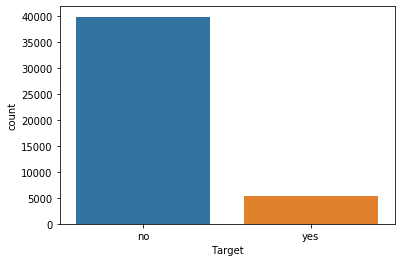

In [9]:
sns.countplot(bank_df['Target'])

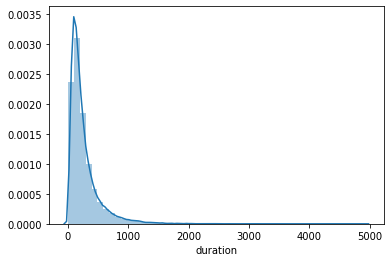

In [10]:
sns.distplot(bank_df['duration'])

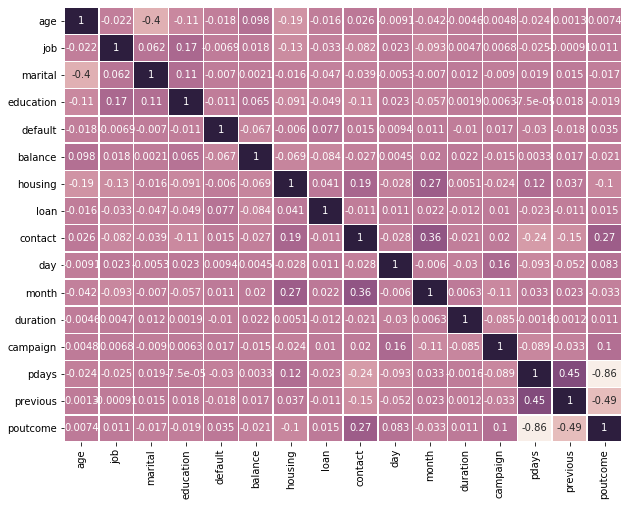

In [31]:
plt.figure(figsize=(10,8))
cmap = sns.cubehelix_palette(light=1, as_cmap=True)
sns.heatmap(bank_df.corr(),
            annot=True,
            linewidths=.5,
            center=0,
            cbar=False,
            cmap=cmap)

plt.show()

C:\Users\User\Anaconda3\lib\site-packages\seaborn\distributions.py:679: UserWarning: Passing a 2D dataset for a bivariate plot is deprecated in favor of kdeplot(x, y), and it will cause an error in future versions. Please update your code.
  warnings.warn(warn_msg, UserWarning)


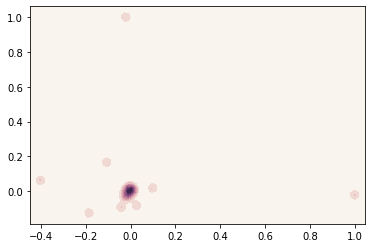

In [34]:
sns.kdeplot(bank_df.corr(), cmap=cmap, shade=True);

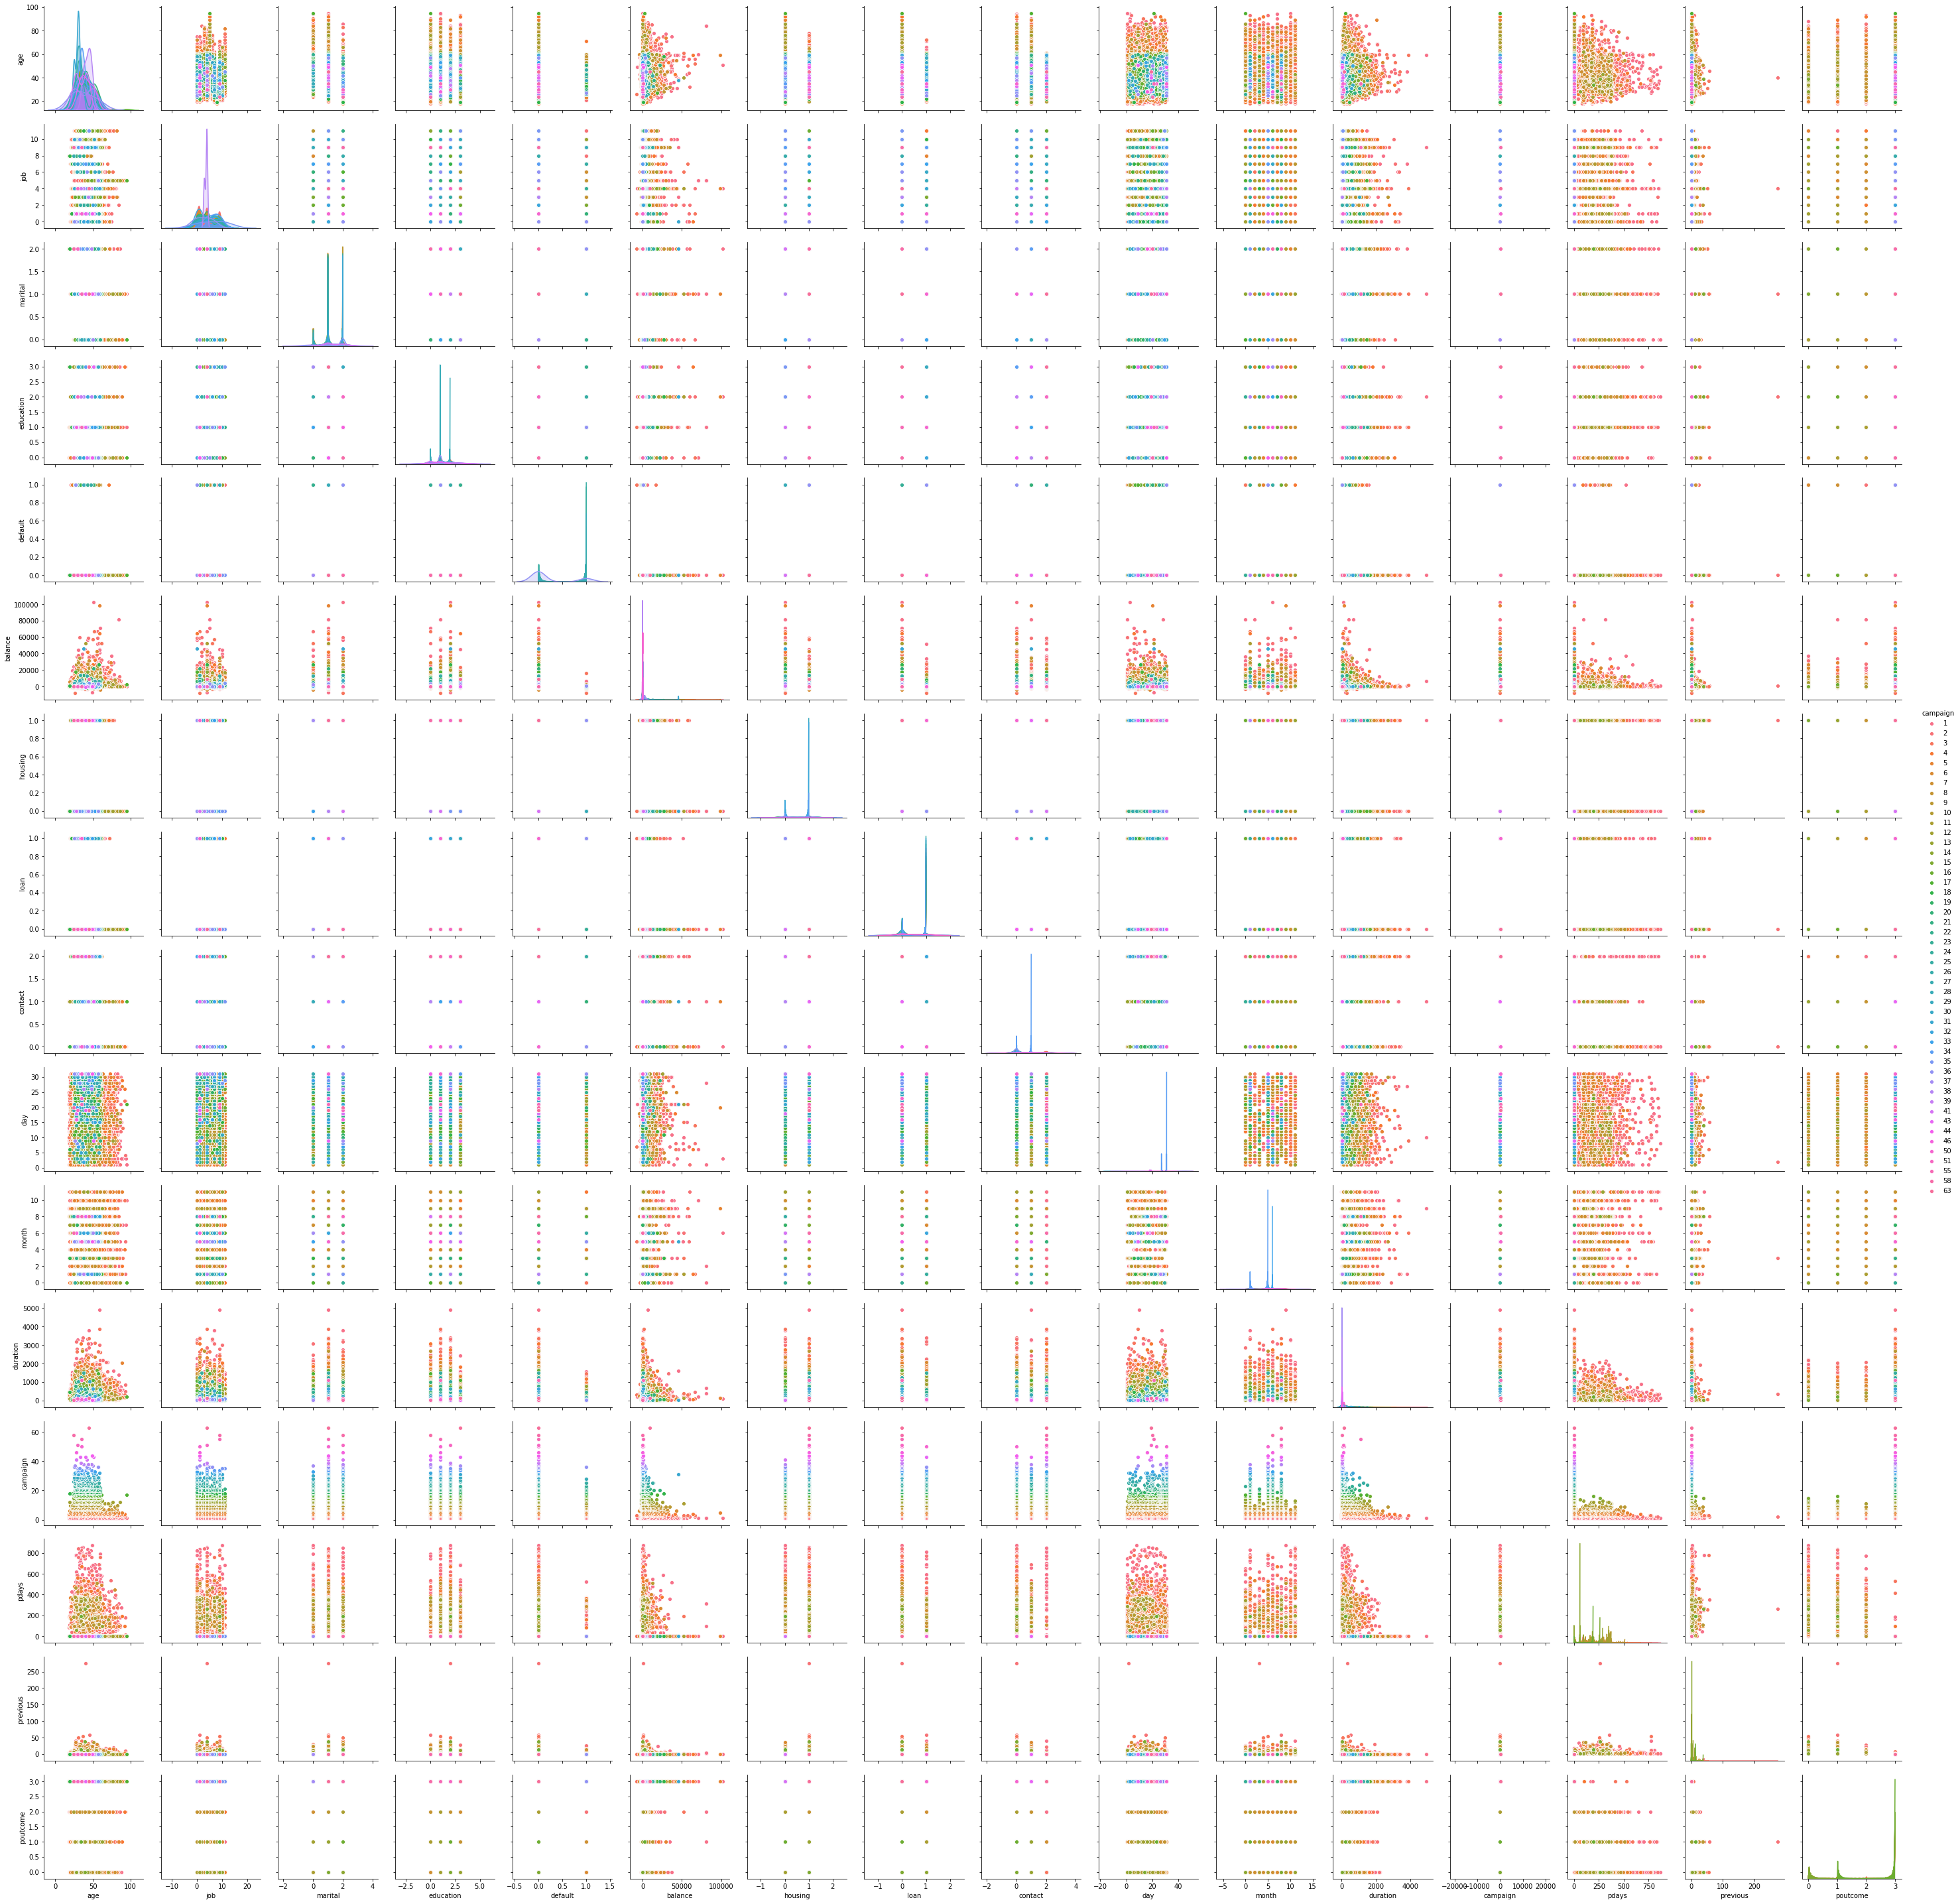

In [36]:
# Scatter Matrix
bank_df_attr = bank_df.iloc[:, 0:16]
# Density Curve
sns.pairplot(bank_df_attr, diag_kind='kde', hue = 'campaign')

# Deliverable – 2 (Prepare the data for analytics)

In [13]:
# Decision tree in Python can take only numerical / categorical colums. It cannot take string / obeject types. 
# The following code loops through each column and checks if the column type is object then converts those columns
# into categorical with each distinct value becoming a category or code.

for feature in bank_df.columns: # Loop through all columns in the dataframe
    if bank_df[feature].dtype == 'object': # Only apply for columns with categorical strings
        bank_df[feature] = pd.Categorical(bank_df[feature]).codes # Replace strings with an integer

In [14]:
bank_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
age          45211 non-null int64
job          45211 non-null int8
marital      45211 non-null int8
education    45211 non-null int8
default      45211 non-null int8
balance      45211 non-null int64
housing      45211 non-null int8
loan         45211 non-null int8
contact      45211 non-null int8
day          45211 non-null int64
month        45211 non-null int8
duration     45211 non-null int64
campaign     45211 non-null int64
pdays        45211 non-null int64
previous     45211 non-null int64
poutcome     45211 non-null int8
Target       45211 non-null int8
dtypes: int64(7), int8(10)
memory usage: 2.8 MB


In [15]:
# Print Header of the file
bank_df.head(10)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,Target
0,58,4,1,2,0,2143,1,0,2,5,8,261,1,-1,0,3,0
1,44,9,2,1,0,29,1,0,2,5,8,151,1,-1,0,3,0
2,33,2,1,1,0,2,1,1,2,5,8,76,1,-1,0,3,0
3,47,1,1,3,0,1506,1,0,2,5,8,92,1,-1,0,3,0
4,33,11,2,3,0,1,0,0,2,5,8,198,1,-1,0,3,0
5,35,4,1,2,0,231,1,0,2,5,8,139,1,-1,0,3,0
6,28,4,2,2,0,447,1,1,2,5,8,217,1,-1,0,3,0
7,42,2,0,2,1,2,1,0,2,5,8,380,1,-1,0,3,0
8,58,5,1,0,0,121,1,0,2,5,8,50,1,-1,0,3,0
9,43,9,2,1,0,593,1,0,2,5,8,55,1,-1,0,3,0


In [16]:
bank_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
age,45211.0,40.936210,10.618762,18.0,33.0,39.0,48.0,95.0
job,45211.0,4.339762,3.272657,0.0,1.0,4.0,7.0,11.0
marital,45211.0,1.167725,0.608230,0.0,1.0,1.0,2.0,2.0
education,45211.0,1.224813,0.747997,0.0,1.0,1.0,2.0,3.0
default,45211.0,0.018027,0.133049,0.0,0.0,0.0,0.0,1.0
balance,45211.0,1362.272058,3044.765829,-8019.0,72.0,448.0,1428.0,102127.0
housing,45211.0,0.555838,0.496878,0.0,0.0,1.0,1.0,1.0
loan,45211.0,0.160226,0.366820,0.0,0.0,0.0,0.0,1.0
contact,45211.0,0.640242,0.897951,0.0,0.0,0.0,2.0,2.0
day,45211.0,15.806419,8.322476,1.0,8.0,16.0,21.0,31.0


In [17]:
# Check for negative numbers and change to zero
#num = bank_df._get_numeric_data()
#num[num < 0] = 0
#bank_df['pdays'][bank_df['pdays'] < 0] = (np.negative(bank_df['pdays']))

bank_df = bank_df.replace(-1,np.nan)
bank_df = bank_df.fillna(0)

In [18]:
bank_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
age,45211.0,40.936210,10.618762,18.0,33.0,39.0,48.0,95.0
job,45211.0,4.339762,3.272657,0.0,1.0,4.0,7.0,11.0
marital,45211.0,1.167725,0.608230,0.0,1.0,1.0,2.0,2.0
education,45211.0,1.224813,0.747997,0.0,1.0,1.0,2.0,3.0
default,45211.0,0.018027,0.133049,0.0,0.0,0.0,0.0,1.0
balance,45211.0,1362.273164,3044.765334,-8019.0,72.0,448.0,1428.0,102127.0
housing,45211.0,0.555838,0.496878,0.0,0.0,1.0,1.0,1.0
loan,45211.0,0.160226,0.366820,0.0,0.0,0.0,0.0,1.0
contact,45211.0,0.640242,0.897951,0.0,0.0,0.0,2.0,2.0
day,45211.0,15.806419,8.322476,1.0,8.0,16.0,21.0,31.0


# Deliverable – 3 (create the ensemble model)

In [19]:
# splitting data into training and test set for independent attributes

train_set = bank_df.head(700) # Up to the last initial training set row
test_set = bank_df.tail(300) # Past the last initial training set row

# capture the target column ("Target") into separate vectors for training set and test set
train_labels = train_set.pop("Target")
test_labels = test_set.pop("Target")

In [ ]:
# splitting data into training and test set for independent attributes

X_train, X_test, y_train, y_test =train_test_split(bank_df.drop('Target',axis=1), bank_df['Target'], test_size=.25,
                                                   random_state=22)
X_train.shape,X_test.shape

In [20]:
# invoking the decision tree classifier function. Using 'entropy' method of finding the split columns. Other option 
# could be gini index.  Restricting the depth of the tree to 3 and size of the leaf node to 5 (no particular reason for 
# selecting this)

model_entropy=DecisionTreeClassifier(criterion='entropy')

In [21]:
model_entropy.fit(X_train, y_train)

NameError: name 'X_train' is not defined

In [ ]:
model_entropy.score(X_train, y_train)  # performance on train data

In [ ]:
model_entropy.score(X_test, y_test)  # performance on test data

In [22]:
credit_labels = bank_df.pop("Target")   #For ensemble, you do not need training and test data separately. 
                                           # bagging can use out of bag records for testing

In [23]:
from sklearn.ensemble import BaggingClassifier
bgcl = BaggingClassifier(n_estimators=50, max_samples=.7 , oob_score=True)

bgcl = bgcl.fit(bank_df, credit_labels)
print(bgcl.oob_score_)

0.9027227887018646


In [24]:
dt_model = DecisionTreeClassifier(criterion = 'entropy', class_weight={0:.5,1:.5}, max_depth = 5, min_samples_leaf=5 )
dt_model.fit(train_set, train_labels)

DecisionTreeClassifier(class_weight={0: 0.5, 1: 0.5}, criterion='entropy',
                       max_depth=5, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [25]:
print(dt_model.score(train_set , train_labels))

print(dt_model.score(test_set , test_labels))  # Relatively less overfit as training and test error are similar

0.99
0.6


In [26]:
clf_pruned = DecisionTreeClassifier(criterion = "entropy", random_state = 100,
                               max_depth=3, min_samples_leaf=5)
clf_pruned.fit(X_train, y_train)

NameError: name 'X_train' is not defined

# Visualizing the tree

In [ ]:
xvar = bank_df.drop('Target', axis=1)
feature_cols = xvar.columns

In [ ]:
dot_data = StringIO()
export_graphviz(clf_pruned, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,feature_names = feature_cols,class_names=['0','1','2'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('bank_pruned.png')
Image(graph.create_png())

In [ ]:
preds_pruned = clf_pruned.predict(X_test)
preds_pruned_train = clf_pruned.predict(X_train)

In [ ]:
print(accuracy_score(y_test,preds_pruned))
print(accuracy_score(y_train,preds_pruned_train))

In [ ]:
acc_DT = accuracy_score(y_test, preds_pruned)

In [ ]:
## Calculating feature importance

feat_importance = clf_pruned.tree_.compute_feature_importances(normalize=False)


feat_imp_dict = dict(zip(feature_cols, clf_pruned.feature_importances_))
feat_imp = pd.DataFrame.from_dict(feat_imp_dict, orient='index')
feat_imp.sort_values(by=0, ascending=False)

In [ ]:
#Store the accuracy results for each model in a dataframe for final comparison
resultsDf = pd.DataFrame({'Method':['Decision Tree'], 'accuracy': acc_DT})
resultsDf = resultsDf[['Method', 'accuracy']]
resultsDf